# Imports

In [9]:
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import ois
from astropy.io import fits
import sep
import astroalign
from matplotlib.patches import Ellipse
%matplotlib inline

In [10]:
from astropy.io.fits import getdata

In [11]:
from astropy.visualization import LinearStretch, LogStretch
from astropy.visualization import ZScaleInterval, MinMaxInterval
from astropy.visualization import ImageNormalize

In [12]:
palette = copy(plt.cm.gray)
palette.set_bad('r', 0.75)

In [13]:
import properimage.single_image as si
from properimage.operations import subtract

# FITS Files

## Set path to reference and science files

In [14]:
#ref_path = "/home/luca/Desktop/Stats/sec32/0.fits"
#new_path = "/home/luca/Desktop/Stats/sec32/imgtemplate2"
#ref_path = "/home/KyleLam/pipeline_tests/test_template/imgtemplate2"
#new_path = '/home/KyleLam/pipeline_tests/test_data/aligned/0.fits'
#ref_path = "/mnt/annex/science_data/m31_s33/2019-08-30/ogg0m406-kb27-20190829-0188-e91.fits.fz"
#new_path = "/mnt/annex/science_data/m31_s33/2019-08-30/ogg0m406-kb27-20190829-0189-e91.fits.fz"
#ref_path = "/home/edgar/real_set/0.fits"
#new_path = "/home/edgar/real_set/1.fits"
ref_path = "/mnt/annex/science_data/RRL_Search/GTAnd_3arc/PTF_201101021226_i_p_scie_t025630_u009604945_f01_p100043_c02_ra11.2910_dec41.5087_asec180.fits"
new_path = "/mnt/annex/science_data/RRL_Search/GTAnd_3arc/PTF_201108231997_i_p_scie_t044738_u010409752_f01_p100043_c02_ra11.2910_dec41.5087_asec180.fits"
#ref_path = "/mnt/annex/science_data/ZTF_test_images/ztf_20180326505509_000589_zg_c10_o_q2_sciimg.fits"
#new_path = "/mnt/annex/science_data/ZTF_test_images/ztf_20180329492454_000589_zg_c10_o_q2_sciimg.fits"

## Load FITS files

In [15]:
new_hduls = fits.open(new_path)
ref_hduls = fits.open(ref_path)
try:
	new_hdul = new_hduls['SCI']
except KeyError:
	try:
		new_hdul = new_hduls['ALGN']
	except KeyError:
		new_hdul = new_hduls['PRIMARY']

try:
	ref_hdul = ref_hduls['SCI']
except KeyError:
	try:
		ref_hdul = ref_hduls['ALGN']
	except KeyError:
		ref_hdul = ref_hduls['PRIMARY']
new_data = new_hdul.data
ref_data = ref_hdul.data

# Alignment

## Align the science data to reference image

In [16]:
aligned_data = np.array([])
try:
	aligned_data = astroalign.register(new_data, ref_data)[0]
except ValueError:
	new_data = new_data.byteswap().newbyteorder()
	aligned_data = astroalign.register(new_data, ref_data)[0]

## Plot Aligned Data

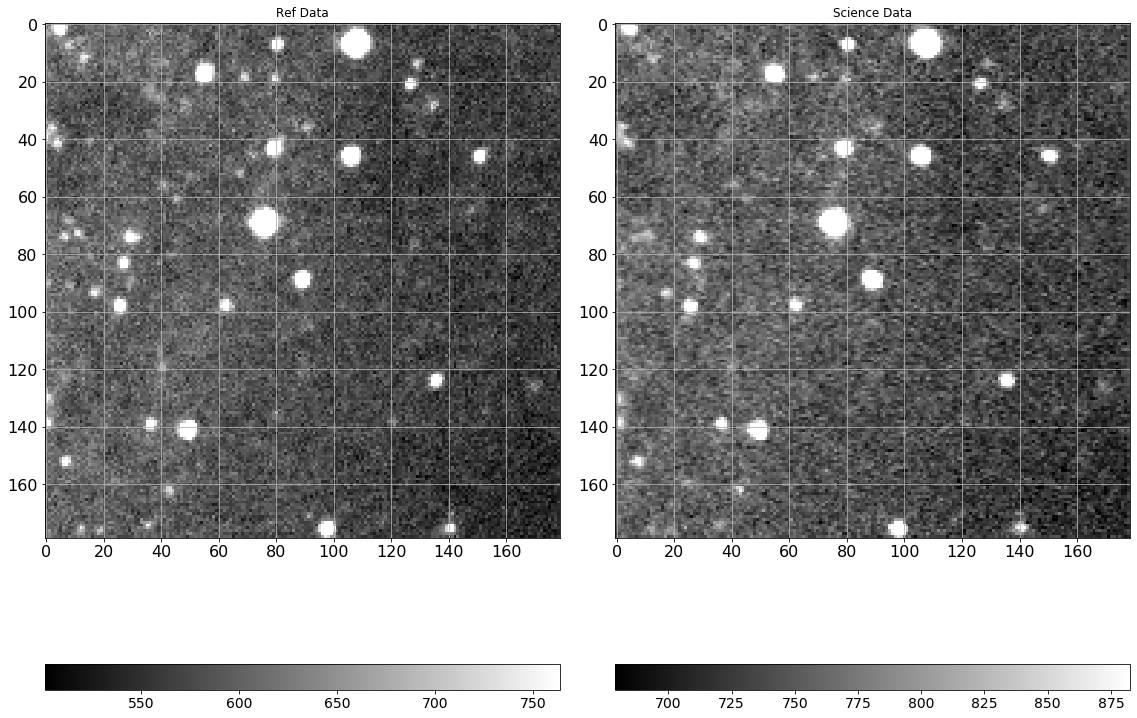

In [17]:
plt.figure(figsize=(16, 12))
plt.subplot(121)
norm = ImageNormalize(ref_data, interval=ZScaleInterval(),
                      stretch=LinearStretch())
plt.imshow(ref_data, cmap=plt.cm.gray, norm=norm, interpolation='none')
plt.title("Ref Data")
plt.tick_params(labelsize=16)
plt.grid()
plt.colorbar(orientation='horizontal').ax.tick_params(labelsize=14)
plt.subplot(122)
norm = ImageNormalize(aligned_data, interval=ZScaleInterval(),
                      stretch=LinearStretch())
plt.imshow(aligned_data, cmap=plt.cm.gray, norm=norm, interpolation='none')
plt.title("Science Data")
plt.tick_params(labelsize=16)
plt.grid()
plt.colorbar(orientation='horizontal').ax.tick_params(labelsize=14)
plt.tight_layout()

# Subtraction

## Set the parameters for ProperImages Subtract

In [18]:
smooth_psf=False
fitted_psf=True
align=False
iterative=False
beta=True
shift=False

## Run ProperImages Subtract

In [19]:
%%time
try:
	result = subtract(ref=ref_data, new=aligned_data, smooth_psf=smooth_psf, fitted_psf=fitted_psf,	align= align, iterative=iterative, beta=beta, shift=shift)
except AttributeError:
	try:
		result = subtract(ref=ref_data.byteswap().newbyteorder(), new=aligned_data, smooth_psf=smooth_psf, fitted_psf=fitted_psf,	align= align, iterative=iterative, beta=beta, shift=shift) 
	except AttributeError:
		try:
			result = subtract(ref=ref_data, new=aligned_data.byteswap().newbyteorder(), smooth_psf=smooth_psf, fitted_psf=fitted_psf,	align= align, iterative=iterative, beta=beta, shift=shift)
		except AttributeError:
			result = subtract(ref=ref_data.byteswap().newbyteorder(), new=aligned_data.byteswap().newbyteorder(), smooth_psf=smooth_psf, fitted_psf=fitted_psf,	align= align, iterative=iterative, beta=beta, shift=shift)


Running Exkalamity's Subtract
Running Exkalamity's Subtract


updating stamp shape to (21,21)
Attempted to use strict star pick, but we had less
                    than 15 srcs to work on. Overriding this.
updating stamp shape to (21,21)


CPU times: user 22.8 s, sys: 0 ns, total: 22.8 s
Wall time: 2 s


In [20]:
D = result[0]
P = result[1]
Scorr = result[2]
mask = result[3]

## Run Bramich Subtract

In [21]:
%%time

diff = ois.optimal_system(image=aligned_data, refimage=ref_data, method='Bramich')[0]

CPU times: user 22.2 s, sys: 22.8 s, total: 44.9 s
Wall time: 749 ms


# Extract Sources

## Set Standard Deviation Threshold

In [22]:
stddev_thresh = 3.0

## Extract Sources for ProperImages

In [23]:
data =np.ascontiguousarray(D.real)
bkg = None
try:
	bkg = sep.Background(data)
except ValueError:
	bkg = sep.Background(data.byteswap().newbyteorder())
pi_sources = sep.extract(data - bkg.back(), bkg.globalrms * stddev_thresh,
                              segmentation_map=False)

## Extract Sources for Bramich

In [24]:
data =np.ascontiguousarray(diff)
bkg = None
try:
	bkg = sep.Background(data)
except ValueError:
	bkg = sep.Background(data.byteswap().newbyteorder())
ois_sources = sep.extract(data - bkg.back(), bkg.globalrms * stddev_thresh,
                              segmentation_map=False)

# Plots

## Plot of ProperImages residual with transients circled

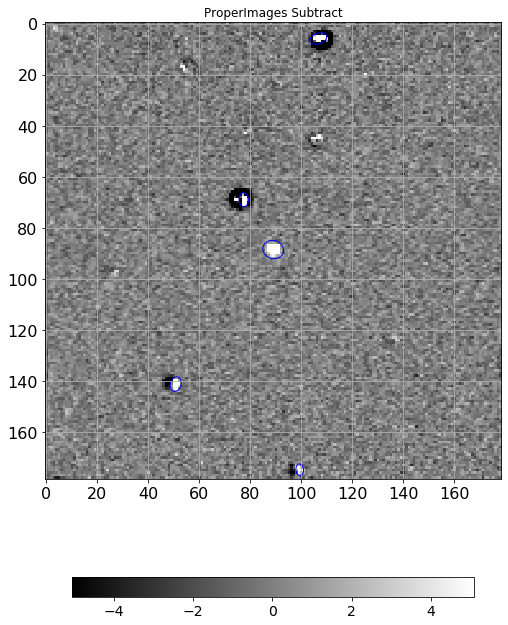

In [25]:
norm = ImageNormalize(D.real, interval=ZScaleInterval(),stretch=LinearStretch())

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(np.ma.MaskedArray(D.real, mask=mask),
            cmap=palette, norm=norm, interpolation='none')
# plt.imshow(D.real,
#             cmap=palette, norm=norm, interpolation='none')
plt.tick_params(labelsize=16)
plt.grid()
plt.title("ProperImages Subtract")
plt.colorbar(im, orientation='horizontal', shrink=0.6).ax.tick_params(labelsize=14)

for i in range(len(pi_sources)):
    e = Ellipse(xy=(pi_sources['x'][i], pi_sources['y'][i]),
                width=6*pi_sources['a'][i],
                height=6*pi_sources['b'][i],
                angle=pi_sources['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('blue')
    ax.add_artist(e)


## Plot of Bramich residual with transients circled

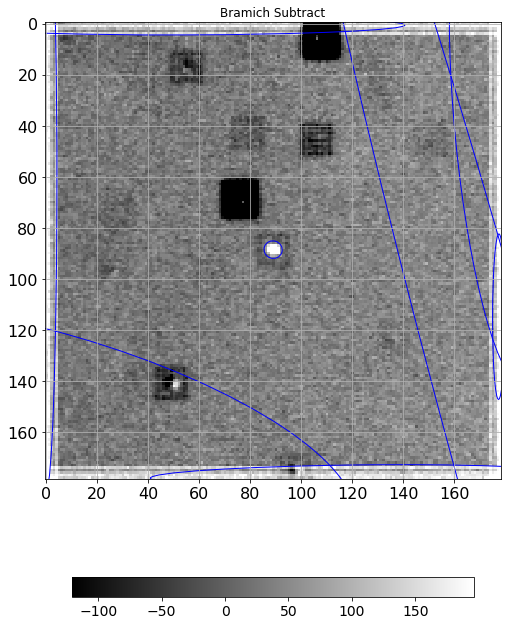

In [26]:
norm = ImageNormalize(diff, interval=ZScaleInterval(),stretch=LinearStretch())

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(diff,
            cmap=palette, norm=norm, interpolation='none')
plt.tick_params(labelsize=16)
plt.grid()
plt.title("Bramich Subtract")
plt.colorbar(im, orientation='horizontal', shrink=0.6).ax.tick_params(labelsize=14)

for i in range(len(ois_sources)):
    e = Ellipse(xy=(ois_sources['x'][i], ois_sources['y'][i]),
                width=6*ois_sources['a'][i],
                height=6*ois_sources['b'][i],
                angle=ois_sources['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('blue')
    ax.add_artist(e)


## Comparison of Bramich vs ProperImages Subtract

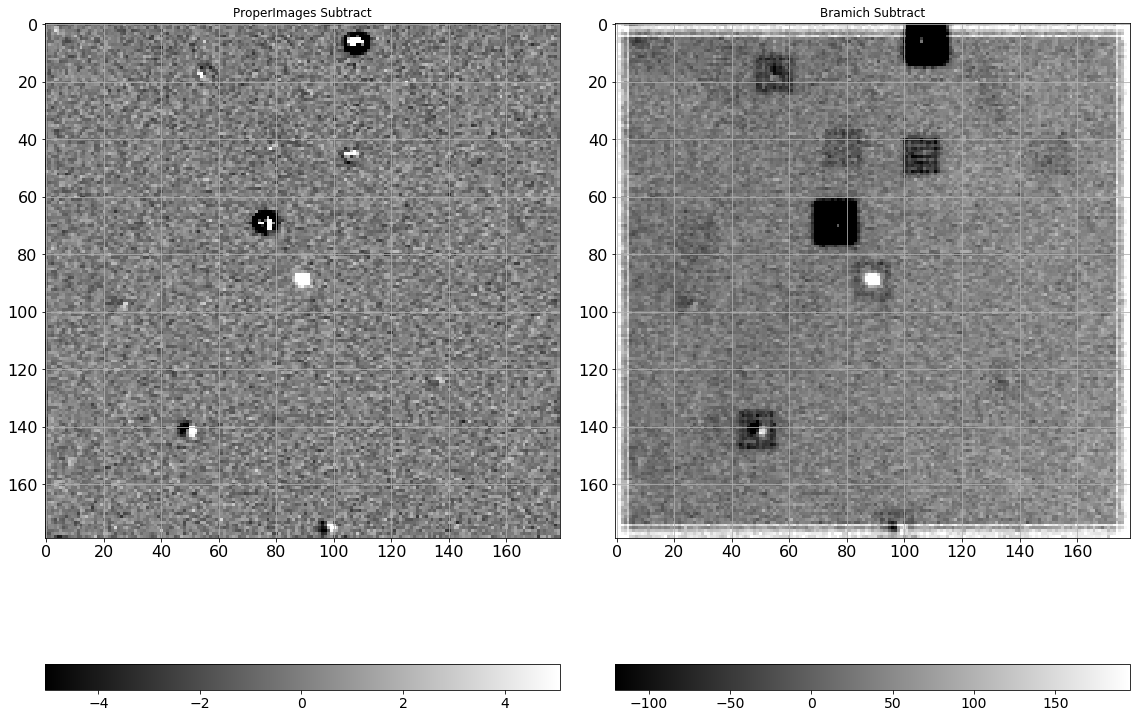

In [27]:
plt.figure(figsize=(16, 12))
norm = ImageNormalize(D.real, interval=ZScaleInterval(),stretch=LinearStretch())

plt.subplot(121)
plt.imshow(D.real,
           cmap=palette, norm=norm, interpolation='none')
plt.tick_params(labelsize=16)
plt.grid()
plt.title("ProperImages Subtract")
plt.colorbar(orientation='horizontal').ax.tick_params(labelsize=14)

norm = ImageNormalize(diff, interval=ZScaleInterval(),stretch=LinearStretch())

plt.subplot(122)
plt.imshow(diff,
           cmap=palette, norm=norm, interpolation='none')
plt.tick_params(labelsize=16)
plt.grid()
plt.title("Bramich Subtract")
plt.colorbar(orientation='horizontal').ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig("ProperImage_vs_Bramich_Subtract_test.jpg", bbox = 'tight')

## Scatterplot of relative locations of transients

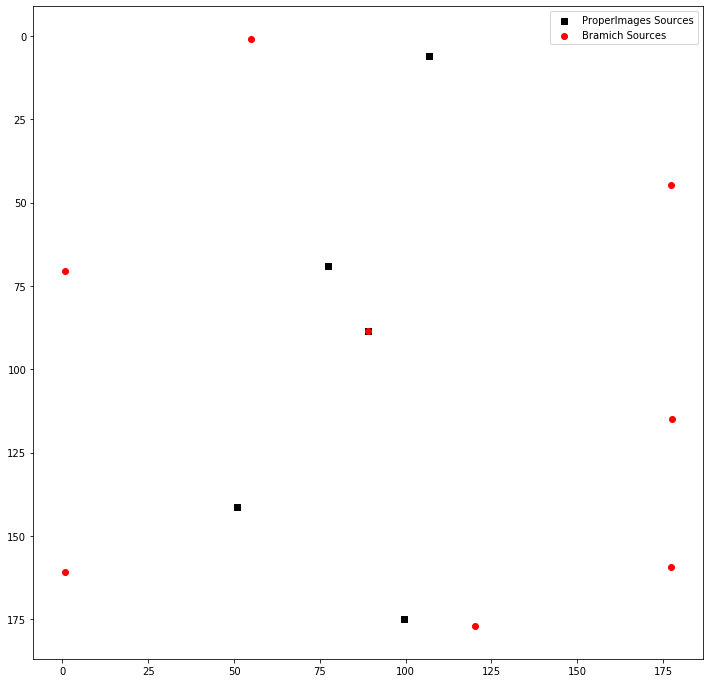

In [28]:
ratio = aligned_data.shape[0]/aligned_data.shape[1]
plt.figure(figsize = (12,12*ratio))
plt.scatter(pi_sources['x'], pi_sources['y'], marker = 's', color = 'k', label = "ProperImages Sources")
plt.scatter(ois_sources['x'], ois_sources['y'], marker = 'o', color = 'r', label = "Bramich Sources")
plt.gca().invert_yaxis()
plt.legend()